<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/harry_potter/Harry_Potter_Karate_Club_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Updated to GDS 2.0 version
* Link to original blog post: https://towardsdatascience.com/integrate-neo4j-with-karateclub-node-embedding-package-99715d73250a

In [1]:
!pip install pandas neo4j scikit-learn karateclub

     |████████████████████████████████| 89 kB 3.8 MB/s 
     |████████████████████████████████| 62 kB 548 kB/s 
     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 24.1 MB 2.2 MB/s 
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.2-py3-none-any.whl size=115365 sha256=4941018e1ed8fd95da841b0f878d0b0b5fe7830d6ac387f5d42f17d2106a054f
  Stored in directory: /root/.cache/pip/wheels/10/d6/28/95029d7f69690dbc3b93e4933197357987de34fbd44b50a0e4
  Created wheel for karateclub: filename=karateclub-1.2.3-py3-none-any.whl size=97754 sha256=54c83ec56a4864ca4fc21b2856d5f7a4bcd86c3e0515fb8abe411b86176f8c1d
  Stored in directory: /root/.cache/pip/wheels/7a/09/80/0d50455fd4e297e88f8f38a711c6f4849e6bd1a330000dde3d
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=2ecbfbdcde0c31ee08f23a76147cc73a61fe17841cfe478691b3ab8124c62e24
  Stored 

In [1]:
import networkx as nx
import pandas as pd
from neo4j import GraphDatabase
# Change the host and user/password combination to your neo4j
host = 'bolt://3.231.25.240:7687'
user = 'neo4j'
password = 'hatchets-visitor-axes'
driver = GraphDatabase.driver(host,auth=(user, password))

def read_query(query, params=None):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

Lately, I have been on a quest to learn as much as possible about node embedding techniques. The goal of node embedding is to encode nodes so that the similarity in the embedding space approximates similarity in the original network. In layman’s terms, we encode each node to a fixed size vector that preserves the similarity of the original network.

I have come across the [Karate Club](https://github.com/benedekrozemberczki/karateclub) package in my search for the implementation of various node embedding models. I will let the author Benedek Rozemberczki explain what its purpose is:
>Karate Club consists of state-of-the-art methods to do unsupervised learning on graph structured data. To put it simply it is a Swiss Army knife for small-scale graph mining research. First, it provides network embedding techniques at the node and graph level. Second, it includes a variety of overlapping and non-overlapping community detection methods. Implemented methods cover a wide range of network science (NetSci, Complenet), data mining (ICDM, CIKM, KDD), artificial intelligence (AAAI, IJCAI) and machine learning (NeurIPS, ICML, ICLR) conferences, workshops, and pieces from prominent journals.

The Karate Club project features:
10+ community detection models
25+ node embedding models
10+ graph embedding models
As you might know, I like to store my network information in Neo4j. In this blog post, I will demonstrate how to extract network information from Neo4j and use it as an input to the Karate Club API. It is a straightforward transformation. We have to transform a Neo4j graph to a NetworkX graph model, as Karate Club uses NetworkX structure, and we are good to go. 

#Data model
We will use a simple toy graph of the Harry Potter universe that I have created in my previous blog post. I have prepared a CSV file with the network structure, so you don’t have to complete the NLP process yourself.

The network is based on the Harry Potter and the Sorcerer’s Stone book. Nodes represent the character in the book, and the INTERACTS relationships represent co-occurrences in the text between characters. To import this network, execute the following Cypher query:
P.s. If you are following along with the Colab notebook, I suggest you open a blank [Neo4j Sandbox project](https://neo4j.com/sandbox/).

In [2]:
# import data
read_query("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/HP/hp_1.csv" as row
MERGE (s:Character{name:row.source})
MERGE (t:Character{name:row.target})
MERGE (s)-[r:INTERACTS]-(t)
SET r.weight = row.weight
RETURN distinct 'import successful' as result
""")

,result
0,import successful


Now that we have our network imported, we can examine the community structure and calculate the node embedding with the help of the Karate Club package.
# Community detection
For those of you that are completely new to Neo4j, I must let you know that Neo4j Graph Data Science plugin provides a couple of community detection algorithms out of the box. I will quickly demonstrate how to use the Louvain algorithm in the GDS library. First you have to project an in-memory graph

In [3]:
read_query("""
CALL gds.graph.project('got', 'Character', {INTERACTS:{orientation:'UNDIRECTED'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Character': {'label': 'Character', 'properti...","{'INTERACTS': {'orientation': 'UNDIRECTED', 'i...",got,119,812,284


Then you can execute any algorithm on the projected graph

In [4]:
read_query("""
CALL gds.louvain.write('got',{
    writeProperty:'louvain'
})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,31,119,0.348028,"[0.28802264068528716, 0.3480277366594676]",2,7,"{'p99': 29, 'min': 8, 'max': 29, 'mean': 17.0,...",3,0,3485,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


A critical detail of the network analysis is that the interaction network between the characters is undirected. I won’t go into the algorithms’ theory or their pros and cons. The goal of this blog post is purely to help you get started with integrating Karate Club and Neo4j. The ideas and differentiation of the algorithms may come in another blog post. Now let’s run some algorithms in KC. KC only works when nodes in the graph have consecutive ids. I don’t know the reason behind this choice; that’s just how it is. We can easily create a mapping to consecutive ids and store it in Neo4j.

In [5]:
# KarateClub only works on nodes with consecutive ids
read_query("""
MATCH (c:Character)
WITH count(*) as number, collect(c) as nodes
UNWIND range(0, number - 1) as index
WITH nodes[index] as node, index
SET node.index = index
RETURN distinct 'done' as result
""")

,result
0,done


In [6]:
# Define character mapping
character_mapping = read_query("""
MATCH (c:Character)
WHERE exists { (c)-[:INTERACTS]-() }
RETURN c.name as character, c.index as index
ORDER BY index
""")

Now, we must export the relevant network data and construct a NetworkX graph model out of it. NetworkX graph can be constructed by only providing the edge list. The syntax of the edge list is:
```
["1 2 {'weight': 3}", "2 3 {'weight': 27}", "3 4 {'weight': 3.0}"]
```
Now, we can go ahead and construct a NetworkX graph model of the Harry Potter universe.

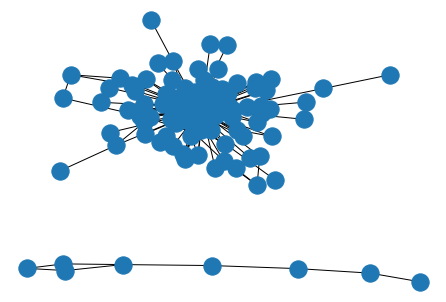

In [7]:
# Construct a networkX graph
edge_list = read_query("""
MATCH (s:Character)-[r:INTERACTS]->(t:Character)
WITH toString(s.index) + " " + toString(t.index) + " {'weight':" + toString(r.weight)  + "}" as edge
WITH collect(edge) as result
RETURN result
""")

edge_list = edge_list['result'].to_list()[0]
G = nx.parse_edgelist(edge_list, create_using=nx.Graph(), nodetype=int)
nx.draw(G)

Take special care to the create_using parameter. In this case, I wanted to define an undirected graph, so I have used the nx.Graph option. If you are dealing with a directed graph or even a multigraph, choose the according create_using parameter.

Now that we have constructed the NetworkX graph, we can go ahead and test KC algorithms. We will begin with a community detection algorithm BigClam. We will calculate the community structure and write the results back to Neo4j.

In [8]:
from karateclub.community_detection.overlapping import BigClam

model = BigClam()
model.fit(G)
results = model.get_memberships()

/home/tomaz/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
data = [{'index': int(el), 'value': int(results[el])} for el in results]
read_query("""
UNWIND $data as row
MATCH (c:Character{index:row.index})
SET c.bigClam = row.value
RETURN distinct 'done' as result
""", {'data':data})

,result
0,done


KC API is very simple to use. You just define the desired graph algorithm and input the NetworkX graph model in the fit method and that’s it. Couldn’t be simpler than that.

# Node embeddings
Again, the Neo4j GDS library provides node embedding algorithms like FastRP, node2vec, and GraphSAGE. I will show the syntax for FastRP algorithm, but again, won’t delve much into hyper-parameter optimization.

In [10]:
read_query("""
CALL gds.fastRP.write('got',{
  embeddingDimension: 64,
  writeProperty: 'fastrp'})
""")

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration
0,119,119,0,100,106,"{'writeConcurrency': 4, 'nodeSelfInfluence': 0..."


The embeddingDimension parameter is mandatory and defines the size of the embedding vector for each node. Other than that, we have again defined the interaction network to be treated as undirected.

Now let’s try out some of the node embedding algorithms in the KC package. First, we will define a function that will draw a t-SNE scatter plot of embedding results.

In [11]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(18,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette=sns.color_palette("hls", 10),
        data=embeddings,
        legend="full",
        alpha=0.9
    )
    
    for i in range(df.shape[0]):
        plt.text(x=df['tsne_x'][i]+0.3,y=df['tsne_y'][i]+0.3,s=df.character[i], 
              fontdict=dict(color='black',size=10),)

We will begin with the NetMF algorithm. NetMF algorithm fall into the community-based node embedding category. If you want to learn more about the technical details, read the original paper or examine the code.

/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


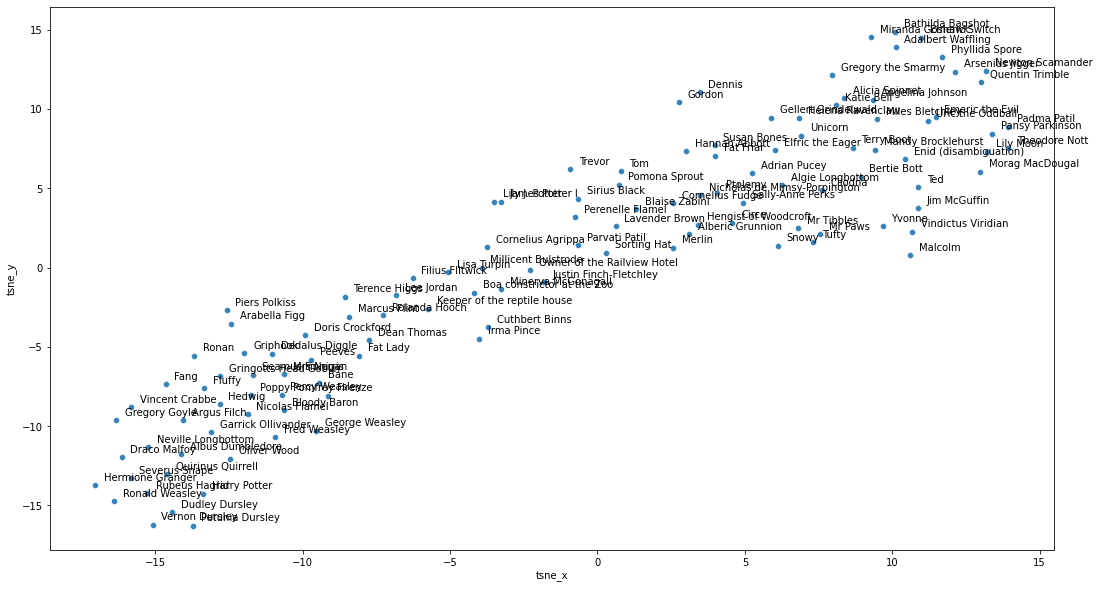

In [12]:
from karateclub.node_embedding.neighbourhood import NetMF

"""
dimensions (int): Number of embedding dimension. Default is 32.
iteration (int): Number of SVD iterations. Default is 10.
order (int): Number of PMI matrix powers. Default is 2.
negative_samples (in): Number of negative samples. Default is 1.
seed (int): SVD random seed. Default is 42.
"""

model = NetMF(dimensions=64)
model.fit(G)
embedding = model.get_embedding()

results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

The KC library also features the NEU algorithm. The procedure uses an arbitrary embedding and augments it by higher order proximities with a recursive meta learning algorithm.

/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


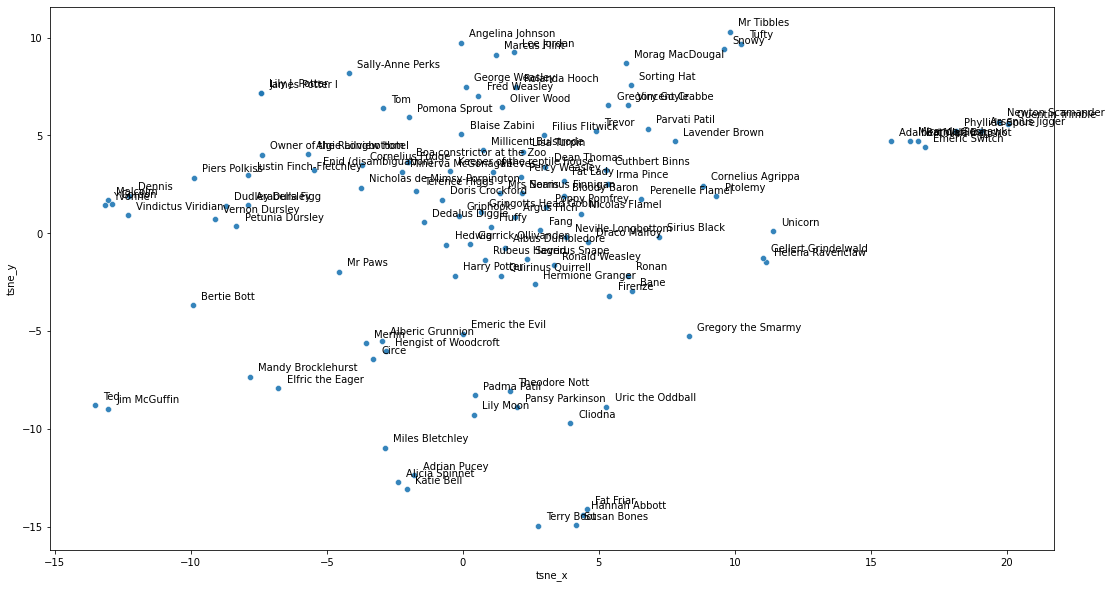

In [13]:
from karateclub.node_embedding.meta import NEU

"""
L1 (float): Weight of lower order proximities. Defauls is 0.5
L2 (float): Weight of higer order proximities. Default is 0.25.
T (int): Number of iterations. Default is 1.
seed (int): Random seed value. Default is 42.
"""

model = NetMF()
meta_model = NEU(T=3)
meta_model.fit(G, model)

embedding = meta_model.get_embedding()
results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

Another node embedding category of algorithms is the structural role embedding category. Instead of capturing the similarity between nodes close in the network (neighbors), we want to capture the similarity between nodes with similar structural roles. One such algorithm is the Role2Vec algorithm.

The default walk_length is 80. Given that our example graph has only 100+ nodes, I have decided to use a smaller walk_length value. Other than that, there is room for more hyper-parameter tweaking.

/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tomaz/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


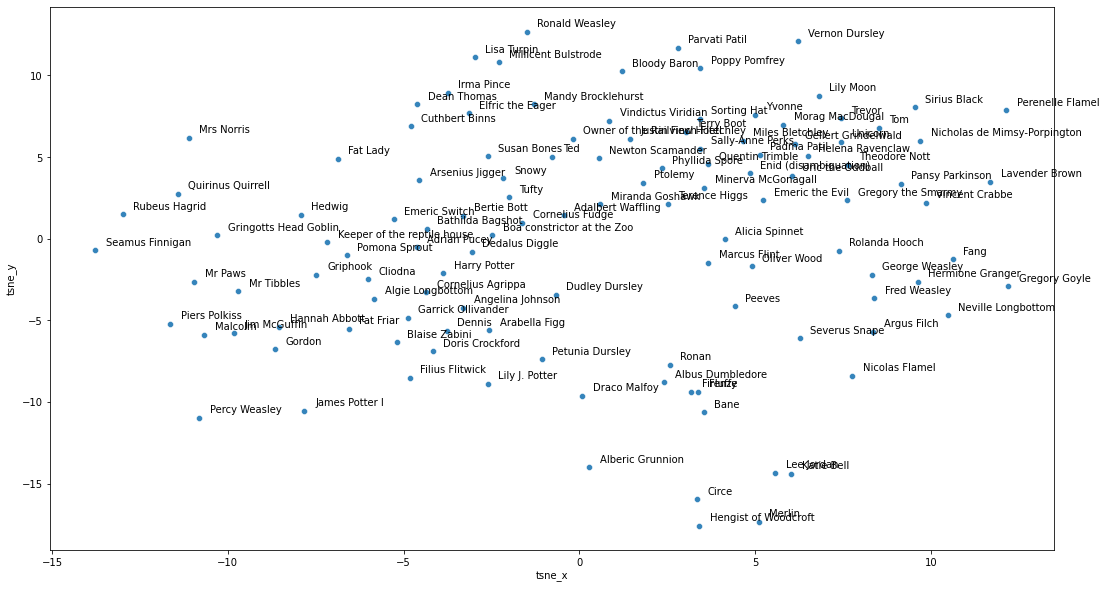

In [14]:
from karateclub.node_embedding.structural import Role2Vec

"""
walk_number (int): Number of random walks. Default is 10.
walk_length (int): Length of random walks. Default is 80.
dimensions (int): Dimensionality of embedding. Default is 128.
workers (int): Number of cores. Default is 4.
window_size (int): Matrix power order. Default is 2.
epochs (int): Number of epochs. Default is 1.
learning_rate (float): HogWild! learning rate. Default is 0.05.
down_sampling (float): Down sampling frequency. Default is 0.0001.
min_count (int): Minimal count of feature occurrences. Default is 10.
wl_iterations (int): Number of Weisfeiler-Lehman hashing iterations. Default is 2.
seed (int): Random seed value. Default is 42.
erase_base_features (bool): Removing the base features. Default is False.
"""

model = Role2Vec(walk_length=20)
model.fit(G)
embedding = model.get_embedding()

results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

Calculating node embedding based on node role similarity is an exciting field. Instead of comparing the closeness of nodes in the network, we want to capture the structural role similarity between nodes. Then, we can use the structural role embedding to infer a kNN network and run a community detection algorithm to try and segment the nodes based on their network roles. First, we have to store the Role2vec results back to Neo4j.

In [15]:
df['embedding'] = [el.tolist() for el in df['embedding']]
data = list(df[['character','embedding']].T.to_dict().values())

read_query("""
UNWIND $data as row
MATCH (c:Character{name:row.character})
SET c.role2vec = row.embedding
RETURN distinct 'done'
""", {'data':data})

,'done'
0,done


The kNN algorithm is featured in the GDS library. The K-Nearest Neighbors algorithm computes a distance value for all node pairs in the graph and creates new relationships between each node and its k nearest neighbors. The distance is calculated based on node properties.
We will take advantage of the Graph Catalog feature as we will run two graph algorithms in sequence. First, we store a projection of a network as a named graph using the following syntax:

In [16]:
#KNN

read_query("""
CALL gds.graph.project('role2vec', 'Character', 'INTERACTS', {nodeProperties:['role2vec']})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Character': {'label': 'Character', 'properti...","{'INTERACTS': {'orientation': 'NATURAL', 'inde...",role2vec,119,406,96


We don’t care about undirected INTERACTS relationships as we will not be using them. The important thing is that we have included the role2vec node embedding in our projection. Now, we can go ahead and mutate the kNN algorithm. Using the mutate method, we store the algorithm results back to the projected named graph instead of the Neo4j stored graph. This way, we can use the results of the kNN algorithm as an input to a community detection algorithm.

In [17]:
read_query("""
CALL gds.knn.mutate('role2vec', {topK: 5, nodeProperties:'role2vec', mutateProperty:'weight', mutateRelationshipType:'SIMILAR_ROLE'})
""")

,ranIterations,nodePairsConsidered,didConverge,preProcessingMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,6,18279,True,0,112,7,-1,119,595,"{'p1': 0.8695907592773438, 'max': 0.9993972778...","{'topK': 5, 'maxIterations': 100, 'randomJoins..."


We will store the resulting relationships under the SIMILAR_ROLE type. One of the parameters is topK, which defines the number of neighbors to find for each node. The K-nearest neighbors are returned. Finally, we can examine the community structure of the resulted similarity network by using the Louvain algorithm.

In [18]:
read_query("""
CALL gds.louvain.write('role2vec', {relationshipTypes:['SIMILAR_ROLE'], writeProperty:'louvain_role'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,13,119,0.612429,[0.6124285008120895],1,8,"{'p99': 33, 'min': 3, 'max': 33, 'mean': 14.87...",2,1,1202,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [19]:
read_query("""
CALL gds.graph.writeRelationship('role2vec', 'SIMILAR_ROLE', 'weight')
""")

,writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
0,183,role2vec,SIMILAR_ROLE,weight,595,595


# Conclusion
The Karate Club package includes node embedding models that take into consideration also node properties. Unfortunately, we don’t have any node properties in our simple Harry Potter network, so I skipped them. Nevertheless, the node embedding research field is fascinating, and there are many approaches to what type of information you want to extract from the network. Hopefully, this simple integration of the Neo4j and Karate Club project will help you use the node embedding models that will work best for you.